Here's the deal. We performed a searchlight analysis on each subject's functional images from runs 1 and 2, producing a functional map representing the objective discriminativity of each voxel between runs. Now we want to visualize these maps, first at the individual level, and also at the group level.

How do we do it?
0. Convert discriminativity maps into .nii.gz format. (Done during searchlight)
1. Pass images through FLIRT, producing .nii.gz files aligned to standard space.
2. Merge all the images through fslmerge.
3. Produce a map of t-statistics from the 4D set of maps using randomise.
4. Make code to visualize the single subject maps on the one hand and the integrated t-statistic map on the other. 

In [2]:
## DESIGN ## ## ## ## 
## There are four objects (bed, bench, chair, table). Participants viewed each object 20 times per run.
## Runs 1 & 2 -- reserved to conduct searchlight
## Runs 3 & 4 -- pretest phase 
## Four training runs involving practice drawing two of the trained objects. 
## Runs 5 & 6 -- posttest phase
## GOAL ## ## ## ## 
## Compare similarity between Trained object representations before and after training (vs. Control) in several
## anatomically-defined ROIs. To do this, define `representation' as cope maps generated 
## upon fitting GLM to each object for each run. Build object x voxel matrix (4xK) for each run, vertically concatenate
## the two runs in each phase, and compute correlation matrix. Consider M = off-diagonal 4x4 block [:4,4:8].
## Make sure the rows are sorted such that the first two are the Trained, and the last two are the Control objects.
## Now take the the top-left 2x2 matrix within M and let's call it M-trained. The bottom-right 2x2 = M-control.
## The diagonal elements of M-trained (A,D depicted below) reflect the representational similarity for the *same* object between runs.
## The off diagonal elements of M-trained (B,C) reflect the similarity between different objects across runs. 
## [_A_|_B_]
## [_C_|_D_]
## Mean of (B,C) - Mean(A,D) = Representational distance between objects in this phase. 

## Setup (conversion into .nii.gz is predone)

In [3]:
import nipype
import os
import nibabel as nib
import numpy as np
from nilearn import image
import matplotlib.pyplot as plt
from nilearn.plotting import plot_roi
from nilearn import plotting

In [4]:
# get locations of searchlight maps
input_dir = '/Users/jordangunn/rsa/searchlight_maps/searchlight_output_nii/'
proj_dir = '/Users/jordangunn/rsa/searchlight_maps/'
sub_dirs = os.listdir(input_dir)

print(sub_dirs)
print(str(len(sub_dirs)) + ' subjects')

['0110171_neurosketchsearchlight.nii.gz', '0110172_neurosketchsearchlight.nii.gz', '0111171_neurosketchsearchlight.nii.gz', '0112171_neurosketchsearchlight.nii.gz', '0112172_neurosketchsearchlight.nii.gz', '0112173_neurosketchsearchlight.nii.gz', '0113171_neurosketchsearchlight.nii.gz', '0115172_neurosketchsearchlight.nii.gz', '0115174_neurosketchsearchlight.nii.gz', '0117171_neurosketchsearchlight.nii.gz', '0118171_neurosketchsearchlight.nii.gz', '0118172_neurosketchsearchlight.nii.gz', '0119171_neurosketchsearchlight.nii.gz', '0119172_neurosketchsearchlight.nii.gz', '0119173_neurosketchsearchlight.nii.gz', '0119174_neurosketchsearchlight.nii.gz', '0120171_neurosketchsearchlight.nii.gz', '0120172_neurosketchsearchlight.nii.gz', '0120173_neurosketchsearchlight.nii.gz', '0123171_neurosketchsearchlight.nii.gz', '0123173_neurosketchsearchlight.nii.gz', '0124171_neurosketchsearchlight.nii.gz', '0125171_neurosketchsearchlight.nii.gz', '0125172_neurosketchsearchlight.nii.gz', '1121161_neuros

## 1. Pass images through FLIRT, producing .nii.gz files aligned to standard space. 

In [37]:
# images should be in searchlight_maps folder, 
# affines should be in the standard folder, 
# standard images will be in the standard folder
# extra standard mat files will be produced in the project directory; just delete these
from nipype.interfaces.fsl import FLIRT

for s in range(len(sub_dirs)):
    for run in ['1', '2']:
        flt = FLIRT()
        flt.inputs.reference = (proj_dir +
                                'MNI152_T1_2mm_brain.nii.gz')
        flt.inputs.in_file = input_dir + sub_dirs[s]
        flt.inputs.apply_xfm = True
        flt.inputs.in_matrix_file = (proj_dir + '/affines/'
                                     + sub_dirs[s][:7] + '_' + run +
                                     '_func2standard.mat')
        flt.inputs.out_file = (proj_dir + 'standard/' +
                               sub_dirs[s][:7] + '_' + run +
                               '_neurosketchsearchlight_standard.nii.gz')
        flt.out_matrix_file = (proj_dir + 'standard/' +
                               sub_dirs[s][:7] + '_' + run +
                               '_neurosketchsearchlight_standard.mat')
        flt.run()

print(flt.cmdline) # print example of command line input
FLIRT.help() # how FLIRT works, if you're interested

flirt -in /Users/jordangunn/rsa/searchlight_maps/searchlight_output_nii/1207162_neurosketchsearchlight.nii.gz -ref /Users/jordangunn/rsa/searchlight_maps/MNI152_T1_2mm_brain.nii.gz -out /Users/jordangunn/rsa/searchlight_maps/standard/1207162_2_neurosketchsearchlight_standard.nii.gz -omat 1207162_neurosketchsearchlight_flirt.mat -applyxfm -init /Users/jordangunn/rsa/searchlight_maps//affines/1207162_2_func2standard.mat
Wraps command **flirt**

Use FSL FLIRT for coregistration.

For complete details, see the `FLIRT Documentation.
<https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FLIRT>`_

To print out the command line help, use:
    fsl.FLIRT().inputs_help()

Examples
--------
>>> from nipype.interfaces import fsl
>>> from nipype.testing import example_data
>>> flt = fsl.FLIRT(bins=640, cost_func='mutualinfo')
>>> flt.inputs.in_file = 'structural.nii'
>>> flt.inputs.reference = 'mni.nii'
>>> flt.inputs.output_type = "NIFTI_GZ"
>>> flt.cmdline # doctest: +ELLIPSIS +ALLOW_UNICODE
'flirt -in structur

## 2. Merge all the images through fslmerge.

In [31]:
# standardized images should be /standard/ directory
# merged files will appear in project directory
from nipype.interfaces.fsl import Merge

run = 1 # (just changed run variable for each run)
merger = Merge()
merger.inputs.in_files = [(proj_dir + 'standard/' + 
                           sub_dirs[s][:7] + '_' + str(run) +
                           '_neurosketchsearchlight_standard.nii.gz'
                          ) for s in range(len(sub_dirs))]
merger.inputs.dimension = 't'
merger.inputs.merged_file = 'merged' + str(run) + '.nii.gz'
merger.run()

print(merger.cmdline + '\n') # command line version of what i ran
Merge.help() # documentation on the method

fslmerge -t merged12.nii.gz /Users/jordangunn/rsa/searchlight_maps/standard/0110171_1_neurosketchsearchlight_standard.nii.gz /Users/jordangunn/rsa/searchlight_maps/standard/0110172_1_neurosketchsearchlight_standard.nii.gz /Users/jordangunn/rsa/searchlight_maps/standard/0111171_1_neurosketchsearchlight_standard.nii.gz /Users/jordangunn/rsa/searchlight_maps/standard/0112171_1_neurosketchsearchlight_standard.nii.gz /Users/jordangunn/rsa/searchlight_maps/standard/0112172_1_neurosketchsearchlight_standard.nii.gz /Users/jordangunn/rsa/searchlight_maps/standard/0112173_1_neurosketchsearchlight_standard.nii.gz /Users/jordangunn/rsa/searchlight_maps/standard/0113171_1_neurosketchsearchlight_standard.nii.gz /Users/jordangunn/rsa/searchlight_maps/standard/0115172_1_neurosketchsearchlight_standard.nii.gz /Users/jordangunn/rsa/searchlight_maps/standard/0115174_1_neurosketchsearchlight_standard.nii.gz /Users/jordangunn/rsa/searchlight_maps/standard/0117171_1_neurosketchsearchlight_standard.nii.gz /U

## 4. Produce a map of t-statistics from the 4D "map" using randomise.

In [32]:
from nipype.interfaces.fsl import Randomise
run = 2
rand = Randomise(in_file='merged' + '12' + '.nii.gz',
                 base_name='merged' + '12',
                 one_sample_group_mean=True, #var_smooth=0,
                 raw_stats_imgs=True, tfce=True, #num_perm=100,
                 terminal_output='none')
rand.run()
print(rand.cmdline + '\n')
Randomise.help()

randomise -i merged12.nii.gz -o "merged12" -1 -R -T

Wraps command **randomise**

FSL Randomise: feeds the 4D projected FA data into GLM
modelling and thresholding
in order to find voxels which correlate with your model

Example
-------
>>> import nipype.interfaces.fsl as fsl
>>> rand = fsl.Randomise(in_file='allFA.nii', mask = 'mask.nii', tcon='design.con', design_mat='design.mat')
>>> rand.cmdline # doctest: +ALLOW_UNICODE
'randomise -i allFA.nii -o "tbss_" -d design.mat -t design.con -m mask.nii'

Inputs::

	[Mandatory]
	in_file: (an existing file name)
		4D input file
		flag: -i %s, position: 0

	[Optional]
	args: (a unicode string)
		Additional parameters to the command
		flag: %s
	base_name: (a unicode string, nipype default value: tbss_)
		the rootname that all generated files will have
		flag: -o "%s", position: 1
	c_thresh: (a float)
		carry out cluster-based thresholding
		flag: -c %.2f
	cm_thresh: (a float)
		carry out cluster-mass-based thresholding
		flag: -C %.2f
	demean:

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less


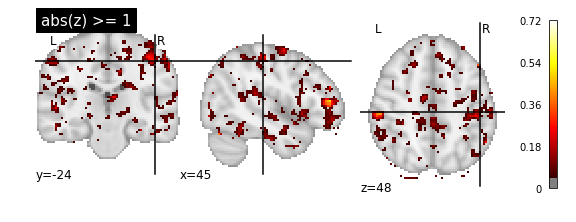

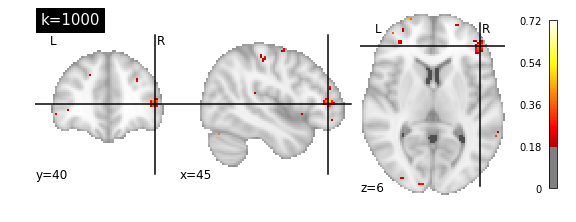

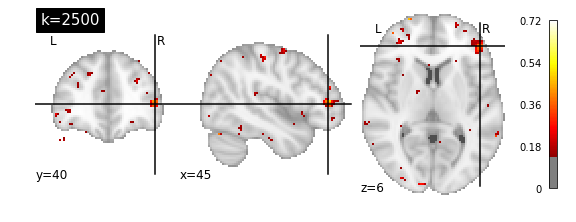

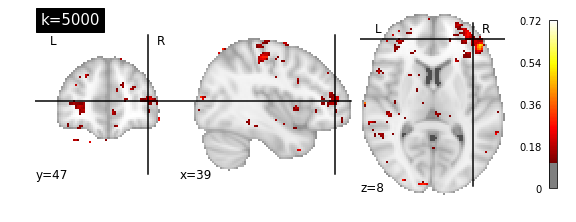

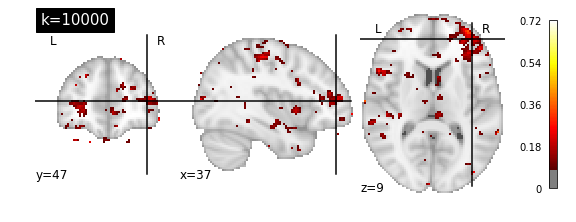

In [26]:
run = 1
individuals = [(proj_dir + 'standard/' +
                sub_dirs[s][:7] + '_' + str(run) +
                '_neurosketchsearchlight_standard.nii.gz'
               ) for s in range(len(sub_dirs))]

for s in [1]:
    subject = individuals[s]
    
    # load subject data
    subject_img = nib.load(subject) # load
    
    # BUTTT
    # decomment this if you want to use the group map instead
    #subject_img = nib.load('merged12_tstat1.nii.gz')
    
    # derive useful info before manipulations
    subject_data = subject_img.get_data()
    dims = np.shape(subject_data)
    size = np.size(subject_data)
    affine = subject_img.affine
    
    # generate new masks for subject based on this data
    # we want one where...
    # values > 1SD above mean are selected
    # top k values for k in [500, 1000, 5000, 10,000, 50,000] are selected
    
    # for the z-score approach, we first find mean and standard deviation of
    # real-valued scores, then the threshold defined by the mean + std
    differences = subject_data.ravel()
    mean = np.nanmean(differences)
    std = np.nanstd(differences)
    threshold = mean + std
    
    # replace subject data with one void of negative values
    subject_data[subject_data < 0] = 0
    
    # plot z-score image
    plotting.plot_stat_map(subject_img, output_file=None, colorbar=True, #cut_coords = (59, 50, 5), #bg_img = None,
                           black_bg = False, title='abs(z) >= 1', threshold = mean + std)
    
    # for the k score approach, we use np.argpartition
    nandiff = differences[~np.isnan(differences)]
    diffsize = np.size(nandiff)
    for k in [1000, 2500, 5000, 10000]:
        threshold = np.partition(nandiff, diffsize-k)[diffsize-k]
        plotting.plot_stat_map(subject_img, output_file=None, colorbar=True, #cut_coords = (59, 0, 5), #bg_img = None,
                               black_bg = False, title='k='+str(k),
                               threshold = np.partition(nandiff, diffsize-k)[diffsize-k])
plt.show()

## Follow-Up

We'll define a new ROI that is the top k voxels for a given subject as defined by their searchlight map. And perform using this mask the same analyses performed in the original prepostRSA notebook.

### Similarity Analysis

In [29]:
# helper functions
def searchlight_mask(subj,run_num,roi,cope_num, k):

    # load occitemp mask, searchlight data, and subject data
    occitemp = load_roi_mask_combined(subj, run_num, 'occitemp').flatten()
    searchlight = np.load('searchlight_output/' +
                          subj + 'searchlight.npy').ravel()
    vol = load_single_run_weights(subj,run_num,cope_num).ravel()
    
    # turn searchlight data into a mask
    differences = searchlight
    nandiff = differences[~np.isnan(differences)]
    diffsize = np.size(nandiff)
    thresh = np.partition(nandiff, diffsize-k)[diffsize-k]
    
    for i in range(len(searchlight)):
        if searchlight[i] is None:
            searchlight[i] = False
        else:
            searchlight[i] = (searchlight[i][1] - searchlight[i][0]) > thresh
    
    return vol[np.logical_and(occitemp, searchlight)==1]

def apply_mask(data,mask):
    return data[mask==1]

def load_data_and_apply_mask(subj,run_num,roi,cope_num, k):
    if roi != 'searchlight':
        vol = load_single_run_weights(subj,run_num,cope_num)
        mask = load_roi_mask_combined(subj,run_num,roi)
        vec = apply_mask(vol,mask)
        return vec
    else:
        return searchlight_mask(subj,run_num,roi,cope_num, k)

def extract_condition_by_voxel_run_mat(this_sub,run_num, roi,k):
    versionNum = coll[this_sub]

    design = [i for i in mdtd if i['version'] == int(versionNum)] # find which axes belong to which condition
    trained = design[0]['trained']
    near = design[0]['near']
    far1 = design[0]['far1']
    far2 = design[0]['far2']

    Tep = getEndpoints(trained)
    Nep = getEndpoints(near)
    condorder = Tep + Nep

    slot1 = load_data_and_apply_mask(
        this_sub,run_num,roi,obj2cope[condorder[0]],k)
    slot2 = load_data_and_apply_mask(
        this_sub,run_num,roi,obj2cope[condorder[1]],k)
    slot3 = load_data_and_apply_mask(
        this_sub,run_num,roi,obj2cope[condorder[2]],k)
    slot4 = load_data_and_apply_mask(
        this_sub,run_num,roi,obj2cope[condorder[3]],k)
    return np.vstack((slot1,slot2,slot3,slot4))

def compare_btw_wit_cond_similarity_across_runs(this_sub,phase,roi,k):
    
    if phase=='pre':
        mat1 = extract_condition_by_voxel_run_mat(this_sub,3,roi,k)
        mat2 = extract_condition_by_voxel_run_mat(this_sub,4,roi,k)
    elif phase=='post':
        mat1 = extract_condition_by_voxel_run_mat(this_sub,5,roi,k)
        mat2 = extract_condition_by_voxel_run_mat(this_sub,6,roi,k)

    fAB = np.vstack((mat1,mat2)) # stack feature matrices
    # square matrix, where off-diagblock is distances *between* 
    # fA and fB vectors
    DAB = pd(fAB, metric='correlation')
    offblock = DAB[:len(mat1),range(len(mat1),shape(DAB)[1])]

    trained_witobj = offblock.diagonal()[:2]
    control_witobj = offblock.diagonal()[2:]
    trained_btwobj = np.array([offblock[:2,:2][0,1], offblock[:2,:2][1,0]])
    control_btwobj = np.array([offblock[2:,2:][0,1],offblock[2:,2:][1,0]])

    trawit_mean = trained_witobj.mean()
    conwit_mean = control_witobj.mean()
    trabtw_mean = trained_btwobj.mean()
    conbtw_mean = control_btwobj.mean()
    return trawit_mean,conwit_mean,trabtw_mean, conbtw_mean 

In [30]:
## Example code block single subject and ROI (searchlight):
this_sub = sub_dirs[0]
run_example = 1
k = 1000
if run_example:
    trawit_mean_pre,conwit_mean_pre,trabtw_mean_pre,conbtw_mean_pre = compare_btw_wit_cond_similarity_across_runs(this_sub,'pre','searchlight',k)
    trawit_mean_post,conwit_mean_post,trabtw_mean_post,conbtw_mean_post = compare_btw_wit_cond_similarity_across_runs(this_sub,'post','searchlight',k)

    tradiff_pre = trabtw_mean_pre - trawit_mean_pre
    condiff_pre = conbtw_mean_pre - conwit_mean_pre

    tradiff_post = trabtw_mean_post - trawit_mean_post
    condiff_post = conbtw_mean_post - conwit_mean_post

    print('Trained Btw-Wit Post-Pre: ' + str(tradiff_post-tradiff_pre))
    print('Control Btw-Wit Post-Pre: ' + str(condiff_post-condiff_pre))  

NameError: name 'coll' is not defined

In [ ]:
### Now compute for all subjects (N=32), and for every ROIs

Tradiffpre = []
Condiffpre = []
Tradiffpost = []
Condiffpost = []

ROIs = ['V1','fusiform','IT','LOC','occitemp', 'searchlight']

for roi in ROIs:
    print(roi)    
    _Tradiffpre = []
    _Condiffpre = []
    _Tradiffpost = []
    _Condiffpost = []
        
    for s in sub_dirs:
        if roi == 'searchlight':
            print(s)
        trawit_mean_pre,conwit_mean_pre, trabtw_mean_pre,conbtw_mean_pre = \
        compare_btw_wit_cond_similarity_across_runs(s,'pre',roi,k)
        trawit_mean_post,conwit_mean_post, trabtw_mean_post,conbtw_mean_post = \
        compare_btw_wit_cond_similarity_across_runs(s,'post',roi,k)
        
        _Tradiffpre.append(trabtw_mean_pre - trawit_mean_pre)
        _Condiffpre.append(conbtw_mean_pre - conwit_mean_pre)

        _Tradiffpost.append(trabtw_mean_post - trawit_mean_post)
        _Condiffpost.append(conbtw_mean_post - conwit_mean_post)
        
    _Tradiffpre,_Condiffpre,_Tradiffpost,_Condiffpost = map(np.array, \
                                                               [_Tradiffpre,_Condiffpre,_Tradiffpost,_Condiffpost])
        
    if len(Tradiffpre)==0:
        Tradiffpre = _Tradiffpre
        Condiffpre = _Condiffpre
        Tradiffpost = _Tradiffpost
        Condiffpost = _Condiffpost
    else:
        Tradiffpre = np.vstack((Tradiffpre,_Tradiffpre))
        Condiffpre = np.vstack((Condiffpre,_Condiffpre))
        Tradiffpost = np.vstack((Tradiffpost,_Tradiffpost))
        Condiffpost = np.vstack((Condiffpost,_Condiffpost))

In [ ]:
## save out so you can import later and share
if shape(Tradiffpre)==(len(ROIs),len(sub_dirs)): ## ONLY save out if you've actually finished the analysis above
    with open("prepost_differentiation_by_condition.pkl", 'wb')  as _f:
        cPickle.dump([Tradiffpost,Tradiffpre,Condiffpost,Condiffpre], _f)

In [ ]:
## load in saved pkl
with open('prepost_differentiation_by_condition.pkl', 'rb') as f:
    prepost_diff = cPickle.load(f, encoding='latin1')

### Sensitivity to measuring differences between object representations separately in each phase

In [34]:
## Make sure that the off-diagonal minus on-diagonal elements (btw-within) in each matrix > 0.
## this indicates that the correlation distance between different objects is larger than that between
## measurements of the same object. This needs to be the case for looking at learning to make sense. 

In [35]:
tmp = np.dstack((Tradiffpre,Condiffpre))
Diffpre = tmp.mean(2)

tmp = np.dstack((Tradiffpost,Condiffpost))
Diffpost = tmp.mean(2)

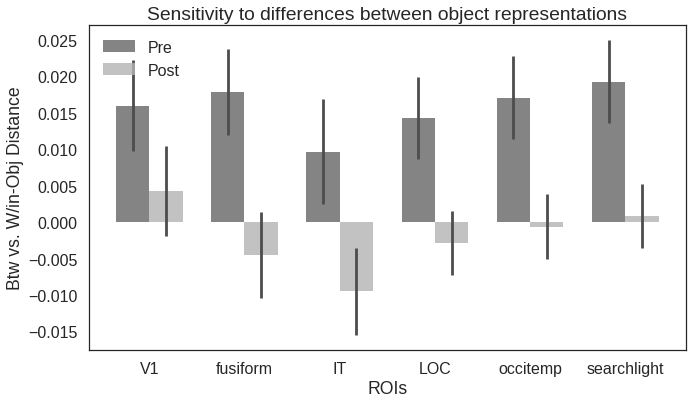

Saving figure to 'plots/object_discriminability_by_roi_group_mean.pdf'...
Done


In [36]:
sns.set_style('white')
sns.set_context('poster')

means_pre = Diffpre.mean(1)
std_pre = Diffpre.std(1)/np.sqrt(shape(Diffpre)[1])

means_post = Diffpost.mean(1)
std_post = Diffpost.std(1)/np.sqrt(shape(Diffpost)[1])

fig, ax = plt.subplots(figsize=(10,6))

n_groups = 6 # num ROIs
index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.8
error_config = {'ecolor': '0.3'}

## plot means as bars
tcolor = (0.4,0.4,0.4)
rects1 = plt.bar(index, means_pre, bar_width,
                 alpha=opacity,
                 color=(0.4,0.4,0.4),
                 yerr=std_pre,
                 error_kw=error_config,
                 label='Pre')

ccolor = (0.7,0.7,0.7)
rects2 = plt.bar(index + bar_width, means_post, bar_width,
                 alpha=opacity,
                 color=(0.7,0.7,0.7),
                 yerr=std_post,
                 error_kw=error_config,
                 label='Post')


plt.xlabel('ROIs')
plt.ylabel('Btw vs. W/in-Obj Distance')
plt.title('Sensitivity to differences between object representations')
plt.xticks(index + bar_width / 2, ('V1','fusiform','IT','LOC','occitemp', 'searchlight'))
plt.legend()
plt.tight_layout()
plt.show()

save_out = 1
if save_out:
    helpers.save('plots/object_discriminability_by_roi_group_mean', ext='pdf', close=False, verbose=True)

### Learning-related changes in representational distance

In [37]:
Tradifflearn = Tradiffpost-Tradiffpre
Condifflearn = Condiffpost-Condiffpre

In [38]:
ROIs = ['V1','fusiform','IT','LOC','occitemp', 'searchlight']
print(Tradifflearn.std(1)/np.sqrt(shape(Tradifflearn)[1]))
print(Condifflearn.mean(1))

[ 0.01155871  0.01024765  0.0102703   0.0087579   0.00835134  0.00883358]
[-0.01165819 -0.02268537 -0.03286402 -0.02582566 -0.02128899 -0.02331462]


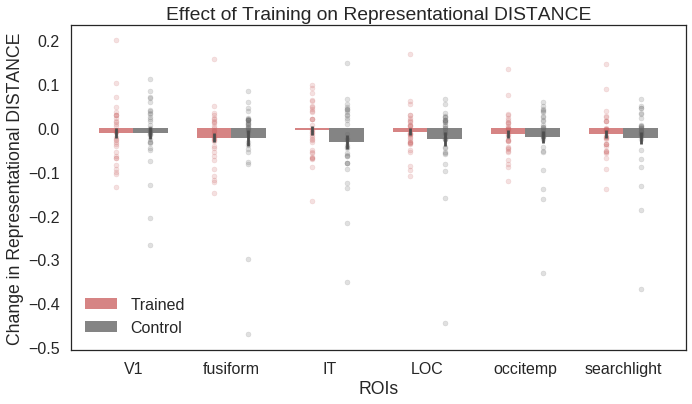

Saving figure to 'plots/differentiation_by_roi_indiv_sub.pdf'...
Done


In [39]:
## Generate summary plot (main analysis)

plot_indiv_subs = 1

sns.set_style('white')
sns.set_context('poster')
means_trained = Tradifflearn.mean(1)
std_trained = Tradifflearn.std(1)/np.sqrt(shape(Tradifflearn)[1])

means_control = Condifflearn.mean(1)
std_control = Condifflearn.std(1)/np.sqrt(shape(Condifflearn)[1])


fig, ax = plt.subplots(figsize=(10,6))

n_groups = 6 # num ROIs
index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.8
error_config = {'ecolor': '0.3'}

## plot means as bars
tcolor = (0.8,0.4,0.4)
rects1 = plt.bar(index, means_trained, bar_width,
                 alpha=opacity,
                 color=(0.8,0.4,0.4),
                 yerr=std_trained,
                 error_kw=error_config,
                 label='Trained')

ccolor = (0.4,0.4,0.4)
rects2 = plt.bar(index + bar_width, means_control, bar_width,
                 alpha=opacity,
                 color=(0.4,0.4,0.4),
                 yerr=std_control,
                 error_kw=error_config,
                 label='Control')

if plot_indiv_subs:
    ## now plot individual subjects as dots
    def generate_concat_tiled(array,reps):        
        inds = []
        for i in index:
            inds.append(np.tile(i,reps))
        return np.reshape(np.array(inds),(1,reps*len(array)))

    tindex = generate_concat_tiled(index,len(Tradifflearn[0]))
    tsubdists = np.reshape(Tradifflearn,(1,shape(Tradifflearn)[0]*shape(Tradifflearn)[1]))
    plt.scatter(tindex,tsubdists,s=25,alpha=0.2,color=tcolor)

    cindex = generate_concat_tiled(index,len(Condifflearn[0]))+bar_width
    csubdists = np.reshape(Condifflearn,(1,shape(Condifflearn)[0]*shape(Condifflearn)[1]))
    plt.scatter(cindex,csubdists,s=25,alpha=0.2,color=ccolor)

plt.xlabel('ROIs')
plt.ylabel('Change in Representational DISTANCE')
plt.title('Effect of Training on Representational DISTANCE')
plt.xticks(index + bar_width / 2, ('V1','fusiform','IT','LOC','occitemp', 'searchlight'))
plt.legend()
plt.tight_layout()
plt.show()

save_out = 1
if save_out:
    if plot_indiv_subs:
        helpers.save('plots/differentiation_by_roi_indiv_sub', ext='pdf', close=False, verbose=True)
    else:
        helpers.save('plots/differentiation_by_roi_group_mean', ext='pdf', close=False, verbose=True)

In [ ]:
## Make sure that the off-diagonal minus on-diagonal elements (btw-within) in each matrix > 0.
## this indicates that the correlation distance between different objects is larger than that between
## measurements of the same object. This needs to be the case for looking at learning to make sense. 

tmp = np.dstack((Tradiffpre,Condiffpre))
Diffpre = tmp.mean(2)

tmp = np.dstack((Tradiffpost,Condiffpost))
Diffpost = tmp.mean(2)

sns.set_style('white')
sns.set_context('poster')

means_pre = Diffpre.mean(1)
std_pre = Diffpre.std(1)/np.sqrt(shape(Diffpre)[1])

means_post = Diffpost.mean(1)
std_post = Diffpost.std(1)/np.sqrt(shape(Diffpost)[1])

fig, ax = plt.subplots(figsize=(10,6))

n_groups = 6 # num ROIs
index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.8
error_config = {'ecolor': '0.3'}

## plot means as bars
tcolor = (0.4,0.4,0.4)
rects1 = plt.bar(index, means_pre, bar_width,
                 alpha=opacity,
                 color=(0.4,0.4,0.4),
                 yerr=std_pre,
                 error_kw=error_config,
                 label='Pre')

ccolor = (0.7,0.7,0.7)
rects2 = plt.bar(index + bar_width, means_post, bar_width,
                 alpha=opacity,
                 color=(0.7,0.7,0.7),
                 yerr=std_post,
                 error_kw=error_config,
                 label='Post')


plt.xlabel('ROIs')
plt.ylabel('Btw vs. W/in-Obj Distance')
plt.title('Sensitivity to differences between object representations')
plt.xticks(index + bar_width / 2, ('V1','fusiform','IT','LOC','occitemp', 'searchlight'))
plt.legend()
plt.tight_layout()
plt.show()

save_out = 1
if save_out:
    helpers.save('plots/object_discriminability_by_roi_group_mean', ext='pdf', close=False, verbose=True)

### Learning-related changes in representational distance

Tradifflearn = Tradiffpost-Tradiffpre
Condifflearn = Condiffpost-Condiffpre

ROIs = ['V1','fusiform','IT','LOC','occitemp', 'searchlight']
print(Tradifflearn.std(1)/np.sqrt(shape(Tradifflearn)[1]))
print(Condifflearn.mean(1))

## Generate summary plot (main analysis)

plot_indiv_subs = 1

sns.set_style('white')
sns.set_context('poster')
means_trained = Tradifflearn.mean(1)
std_trained = Tradifflearn.std(1)/np.sqrt(shape(Tradifflearn)[1])

means_control = Condifflearn.mean(1)
std_control = Condifflearn.std(1)/np.sqrt(shape(Condifflearn)[1])


fig, ax = plt.subplots(figsize=(10,6))

n_groups = 6 # num ROIs
index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.8
error_config = {'ecolor': '0.3'}

## plot means as bars
tcolor = (0.8,0.4,0.4)
rects1 = plt.bar(index, means_trained, bar_width,
                 alpha=opacity,
                 color=(0.8,0.4,0.4),
                 yerr=std_trained,
                 error_kw=error_config,
                 label='Trained')

ccolor = (0.4,0.4,0.4)
rects2 = plt.bar(index + bar_width, means_control, bar_width,
                 alpha=opacity,
                 color=(0.4,0.4,0.4),
                 yerr=std_control,
                 error_kw=error_config,
                 label='Control')

if plot_indiv_subs:
    ## now plot individual subjects as dots
    def generate_concat_tiled(array,reps):        
        inds = []
        for i in index:
            inds.append(np.tile(i,reps))
        return np.reshape(np.array(inds),(1,reps*len(array)))

    tindex = generate_concat_tiled(index,len(Tradifflearn[0]))
    tsubdists = np.reshape(Tradifflearn,(1,shape(Tradifflearn)[0]*shape(Tradifflearn)[1]))
    plt.scatter(tindex,tsubdists,s=25,alpha=0.2,color=tcolor)

    cindex = generate_concat_tiled(index,len(Condifflearn[0]))+bar_width
    csubdists = np.reshape(Condifflearn,(1,shape(Condifflearn)[0]*shape(Condifflearn)[1]))
    plt.scatter(cindex,csubdists,s=25,alpha=0.2,color=ccolor)

plt.xlabel('ROIs')
plt.ylabel('Change in Representational DISTANCE')
plt.title('Effect of Training on Representational DISTANCE')
plt.xticks(index + bar_width / 2, ('V1','fusiform','IT','LOC','occitemp', 'searchlight'))
plt.legend()
plt.tight_layout()
plt.show()

save_out = 1
if save_out:
    if plot_indiv_subs:
        helpers.save('plots/differentiation_by_roi_indiv_sub', ext='pdf', close=False, verbose=True)
    else:
        helpers.save('plots/differentiation_by_roi_group_mean', ext='pdf', close=False, verbose=True)